In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price/sample_submission.csv
/kaggle/input/car-price/train.csv
/kaggle/input/car-price/test.csv


In [2]:
# for eda
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


#modeling
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder,FunctionTransformer, OrdinalEncoder
from sklearn.metrics import matthews_corrcoef, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold


In [3]:
#Model library
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor,Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
random_state = 42

In [5]:
df_train = pd.read_csv('/kaggle/input/car-price/train.csv',index_col = 'id')
df_test = pd.read_csv('/kaggle/input/car-price/test.csv', index_col = 'id')
df_sub = pd.read_csv('/kaggle/input/car-price/sample_submission.csv')

In [6]:
df_train.sample(4)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
57356,Acura,NSX Base,2023,6523,Hybrid,3.5L V6 24V PDI DOHC Twin Turbo Hybrid,10-Speed Automatic,Black,Ebony,None reported,NaN,56750
42124,MINI,Cooper S Base,2011,103000,Gasoline,180.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,Silver,Black,None reported,Yes,8500
125513,Audi,A4 2.0T Premium Plus quattro,2012,111773,Gasoline,211.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Black,None reported,Yes,21500
180389,Jeep,Gladiator Overland,2020,44000,Gasoline,285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,52000


In [7]:
print("Train set shape")
df_train.shape

Train set shape


(188533, 12)

In [8]:
print("Test set shape")
df_test.shape

Test set shape


(125690, 11)

In [9]:
print("missing values Train set")
df_train.isnull().sum()

missing values Train set


brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [10]:
print("missing values test set")
df_test.isnull().sum()

missing values test set


brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [11]:
df_train.duplicated().sum()

0

In [12]:
df_test.duplicated().sum()

0

In [13]:
print("Train set description")
df_train.describe().T # transposed table by ".T"

Train set description


,count,mean,std,min,25%,50%,75%,max
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


In [14]:
print("Test set description")
df_test.describe() # non Transposed table

Test set description


,model_year,milage
count,125690.000000,125690.000000
mean,2015.797526,66042.581510
std,5.673797,50223.858435
min,1974.000000,100.000000
25%,2013.000000,24500.000000
50%,2017.000000,57500.000000
75%,2020.000000,95798.000000
max,2024.000000,405000.000000


In [15]:
print("information of each column in Train set")
df_train.info()

information of each column in Train set
<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [16]:
print("information of each column in the test set")
df_test.info()

information of each column in the test set
<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 11.5+ MB


In [17]:
features = ['brand','model','model_year','milage','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title','price']
numeric_feats = ['milage']
cat_feats = ['brand','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title','model_year','model']

In [18]:
print(features)
print(numeric_feats)
print(cat_feats)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']
['milage']
['brand', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'model_year', 'model']


# Visualization

In [19]:
def plot_missing_values(df,title,color):
    missing_ratio = df.isnull().sum()/len(df)*100
    missing_df = pd.DataFrame({'column': missing_ratio.index,'missing_ratio':missing_ratio.values})
    
    plt.figure(figsize=(15,5))
    plt.grid(True)
    ax = sns.barplot(x= 'column', y = 'missing_ratio', data = missing_df,color = color)
    
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(title)
    
    plt.yticks(range(0,101,20))
    plt.ylabel("missing values ratio(%)")
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height+0.8,
               '{:.1f}%'.format(height),ha = 'center')
    
    plt.tight_layout()
    plt.show()

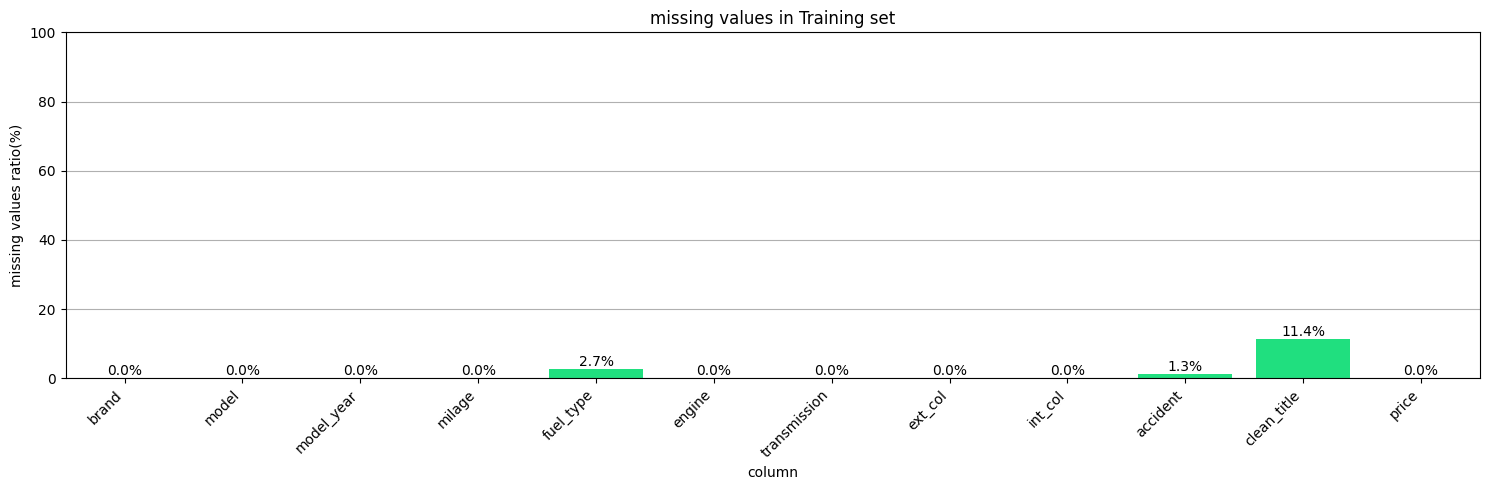

In [20]:
plot_missing_values(df_train,"missing values in Training set", '#00FF7F')


Dealing with the missing values

we wont delete the values as number of missing values are very less, additionally the values that are missing are not numerical, which by the number of missing values and the nature of it, suggests that they are left intentionally.

filling the values- Imputing
1. fuel type -  by the most frequent value
2. accident and clean_title as 'missing'.

In [21]:
def clean_the_data(df):
    fuel_type_imputer = SimpleImputer(strategy = 'most_frequent')
    df['fuel_type'] = fuel_type_imputer.fit_transform(df[['fuel_type']]).ravel()
    
    missing_label_imputer = SimpleImputer(strategy = 'constant', fill_value = "missing")
    df[['accident','clean_title']] = missing_label_imputer.fit_transform(df[['accident','clean_title']])
    
    return df

In [22]:
df_train_cleaned = clean_the_data(df_train)
df_train_cleaned.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [23]:
df_test_cleaned = clean_the_data(df_test)
df_test_cleaned.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

# Encoding

In [24]:
numeric_feats

['milage']

In [25]:
cat_feats

['brand',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'model_year',
 'model']

In [26]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

In [27]:
cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1))
])

In [28]:
preprocessing = ColumnTransformer([
    ('num',num_pipeline, numeric_feats),
    ('cat',cat_pipeline, cat_feats),
])

In [29]:
def pltNum_dist(df, target):
    plt.figure(figsize=(10,6))
    
    sns.histplot(df[target],kde = True, bins=30, color = 'green')
    plt.title(f'Distribution of{target}')
    plt.xlabel(target)
    plt.ylabel("frequency")
    plt.grid(True)
    plt.show()
              


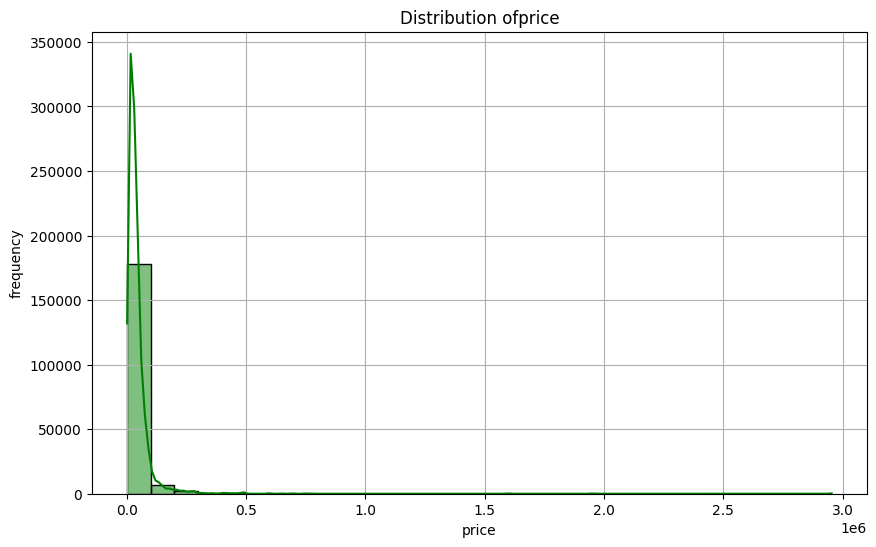

In [30]:
pltNum_dist(df_train_cleaned, 'price')

In [31]:
def plot_outlier_detection(df, target):
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    sns.boxplot(x= df[target],color = 'purple')
    plt.title(f'Box plot of {target}')
    plt.xlabel(target)
    
    plt.subplot(1,2,2)
    sns.violinplot(x=df[target],color = 'pink')
    plt.title(f'Violin plot of{target}')
    plt.xlabel(target)
    
    plt.tight_layout()
    plt.show()

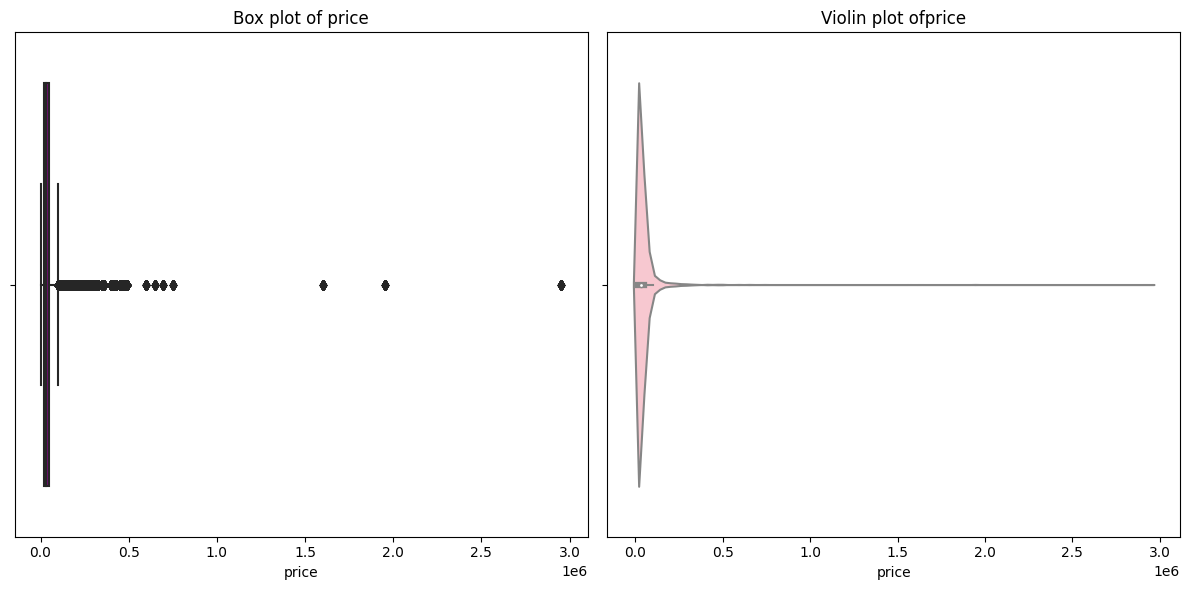

In [32]:
plot_outlier_detection(df_train_cleaned, 'price')

# Numerical Feature Distribution

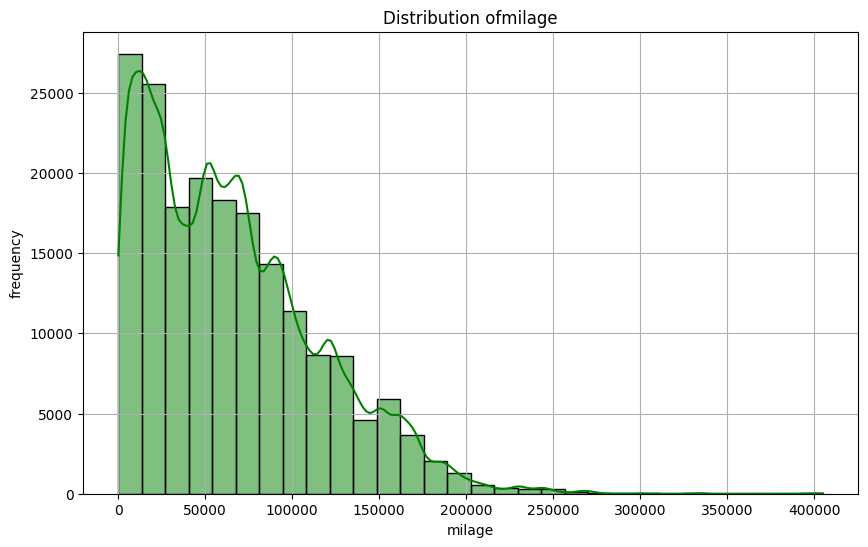

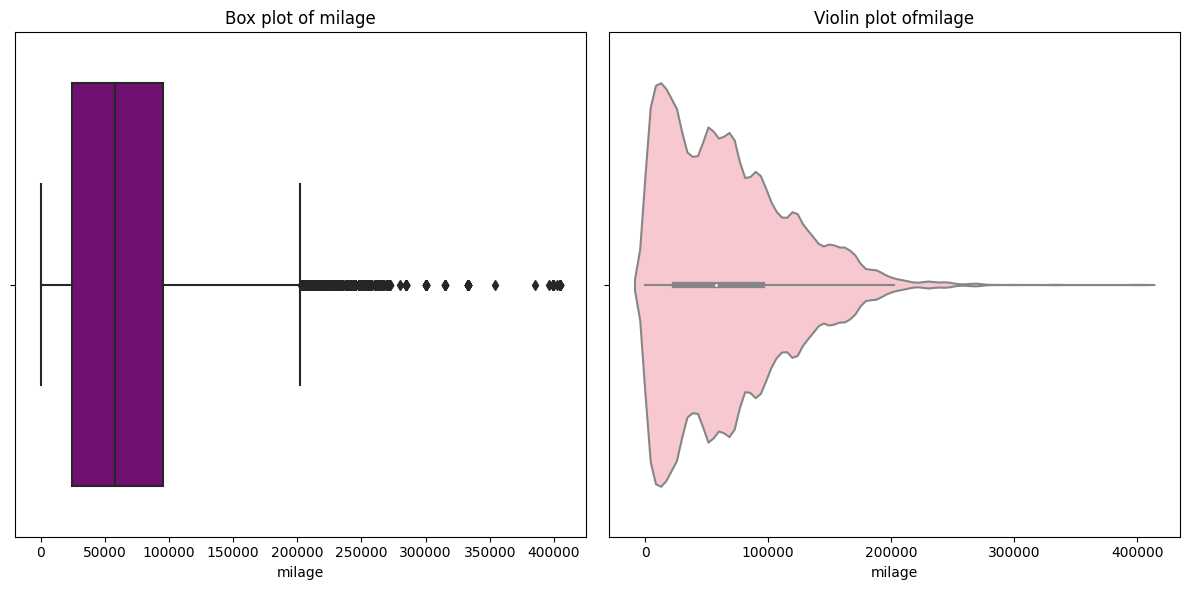

In [33]:
pltNum_dist(df_train_cleaned, 'milage')
plot_outlier_detection(df_train_cleaned,'milage')

# Categorical Feature Distribution
Word Cloud

In [34]:
cat_features_word = ['model','brand','engine','ext_col','int_col']

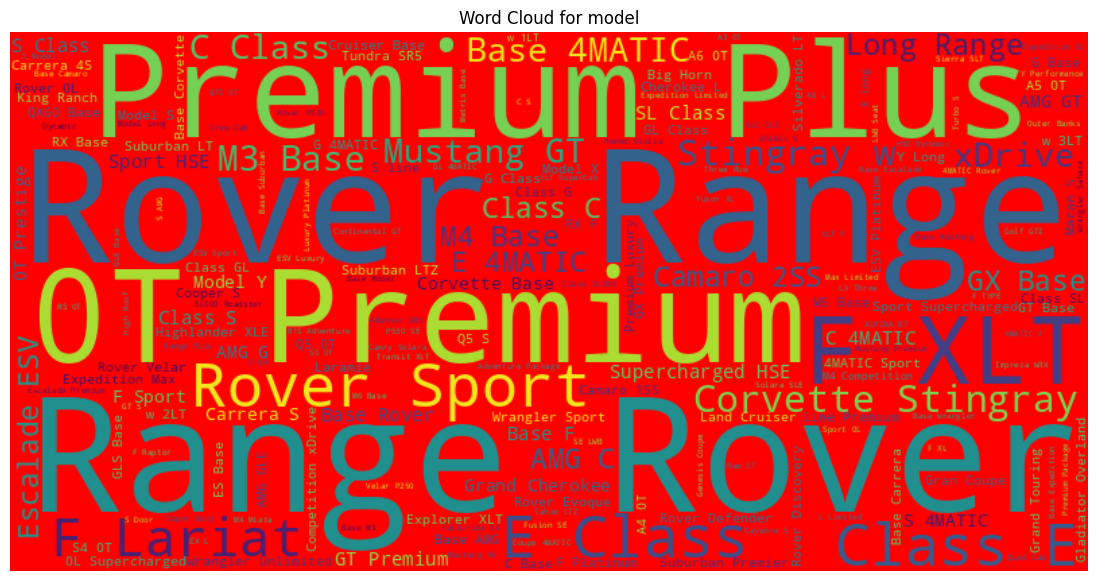

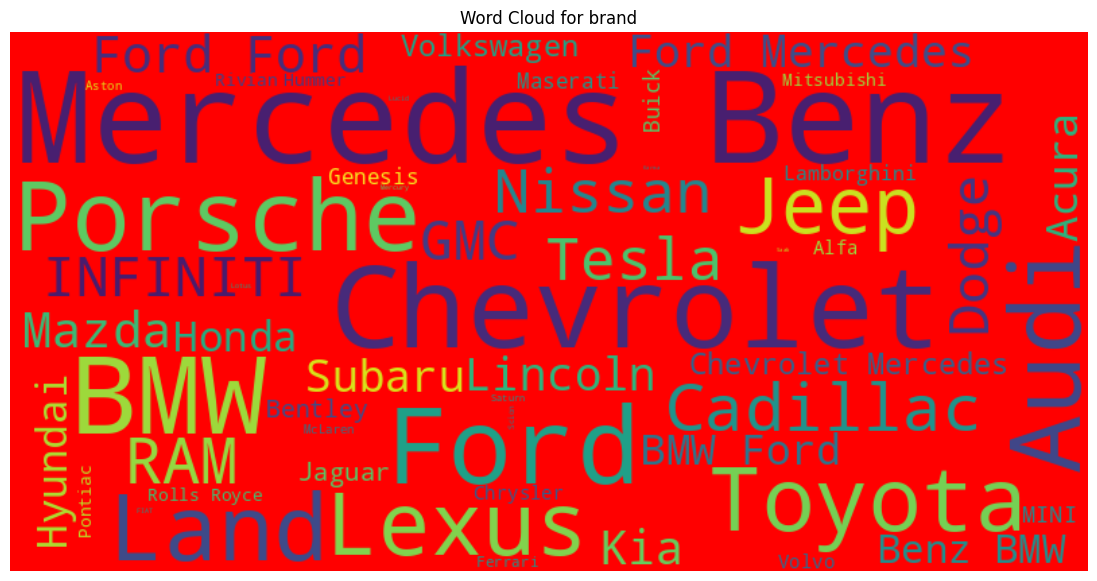

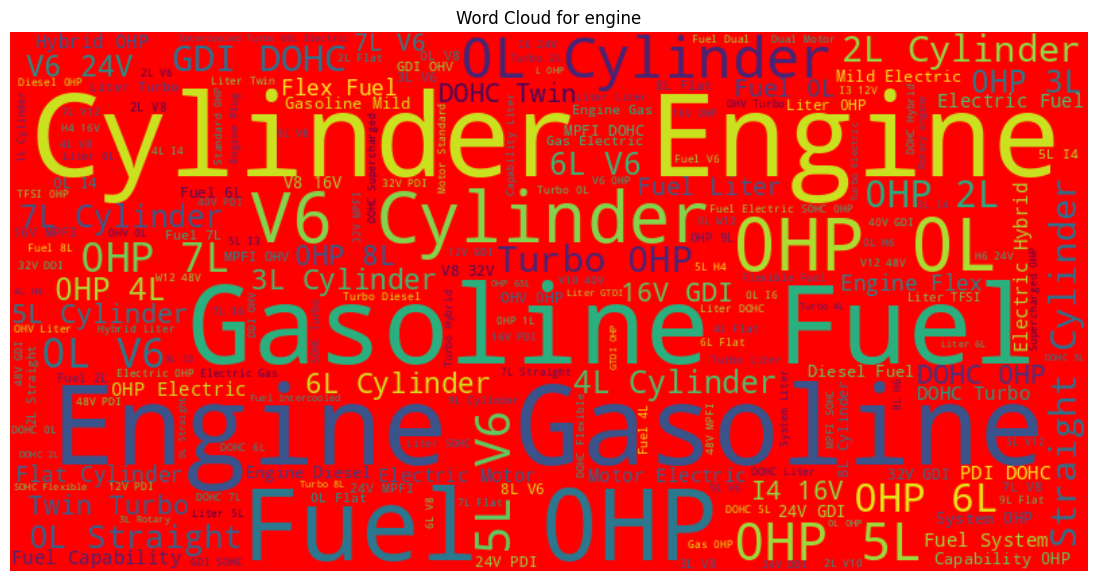

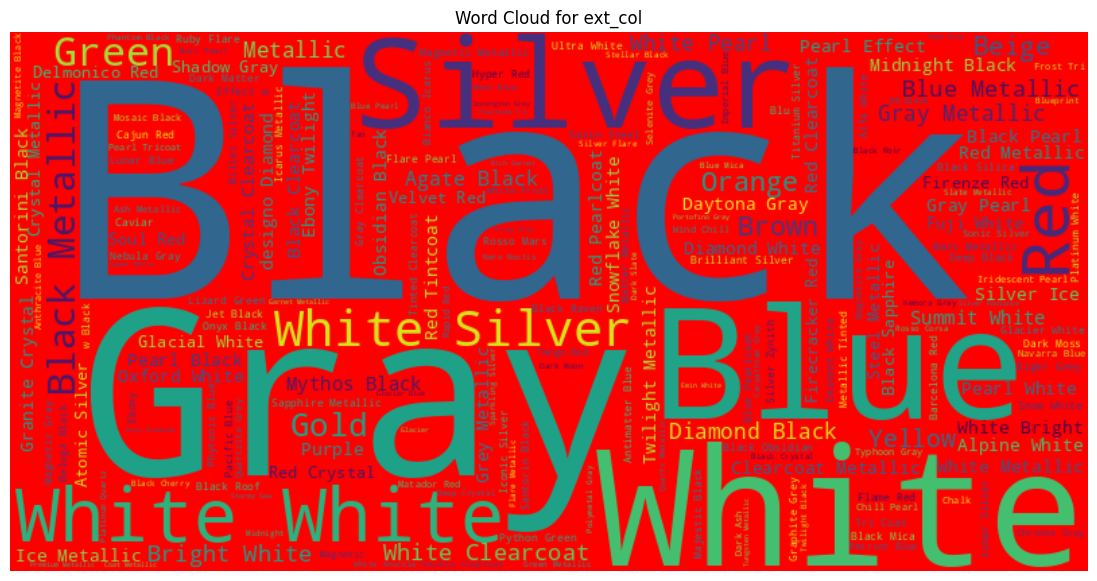

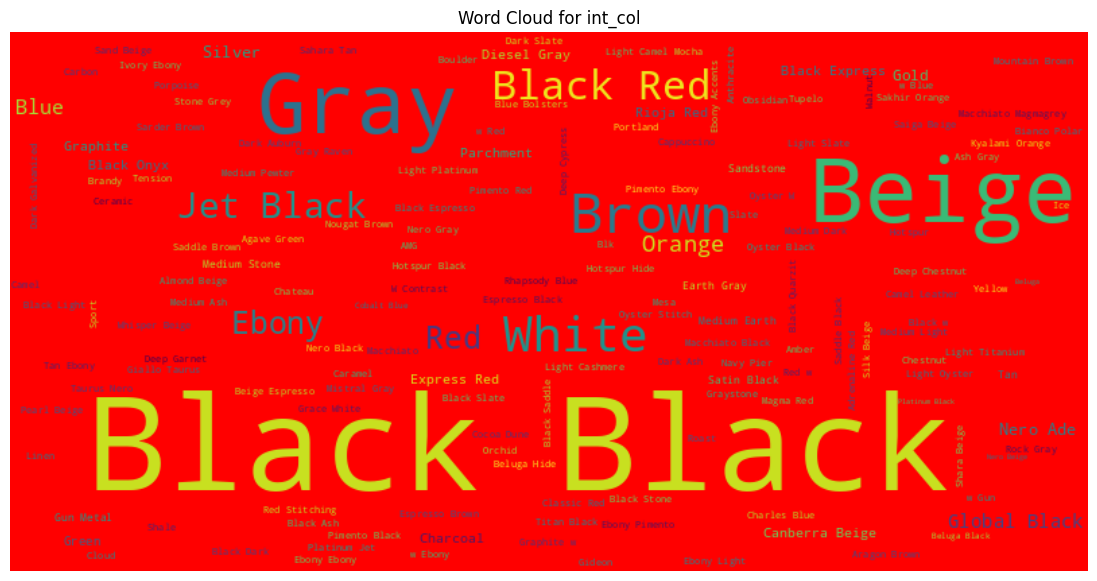

In [35]:
for feature in cat_features_word:
    text = ' '.join(df_train_cleaned[feature].astype(str).values)
    wordcloud = WordCloud(width=800, height = 400, background_color = 'red').generate(text)
    
    plt.figure(figsize= (14,7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {feature}')
    plt.subplots_adjust(hspace=3)
    plt.show()

# Correlationship between Numerical Features and target

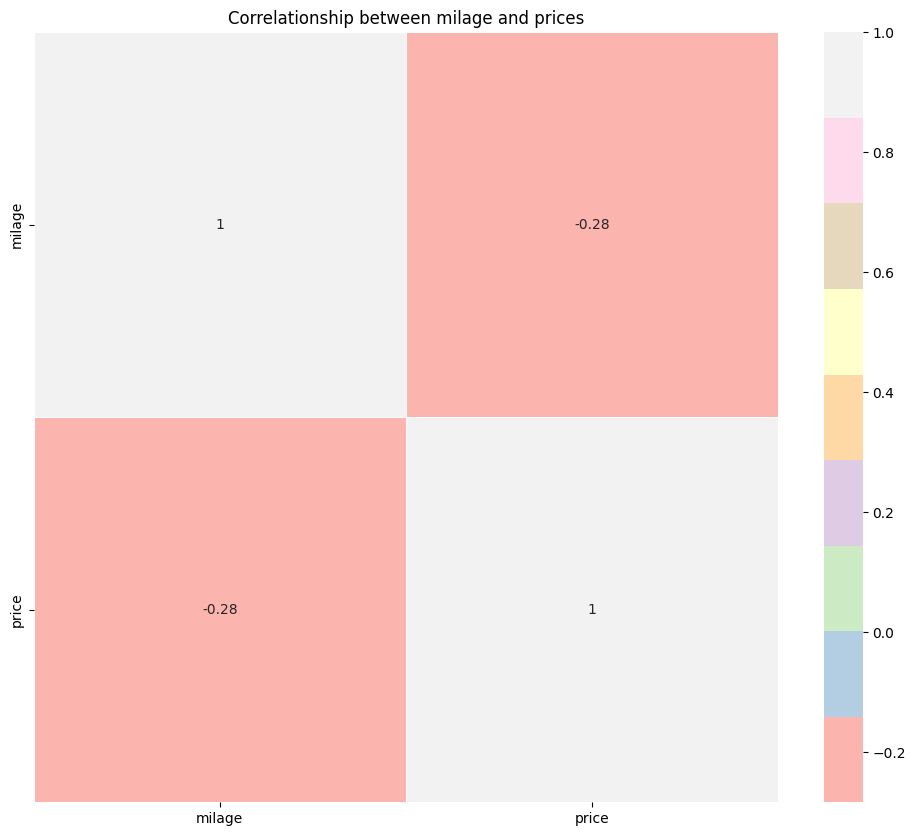

In [36]:
milage_price = ['milage','price']

corr_mat = df_train_cleaned[milage_price].corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr_mat, annot = True, cmap='Pastel1',linewidths=0.5)
plt.title("Correlationship between milage and prices")
plt.show()

# Model and Eval

In [37]:
X = df_train_cleaned.drop(columns=['price'])
y = df_train_cleaned['price']

X_test = df_test_cleaned

In [38]:
rmses = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

for fold, (train_idx,valid_idx) in enumerate(skf.split(X,y)):
    print(f' Fold{fold+1} Training')
    
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_valid = X.loc[valid_idx]
    y_valid = y.loc[valid_idx]
    X_test = X_test
    
    for cat_col in cat_feats:
        X_train[cat_col] = X_train[cat_col].astype(str)
        X_valid[cat_col] = X_valid[cat_col].astype(str)
        X_test[cat_col] = X_test[cat_col].astype(str)
        
    X_train_pool = Pool(X_train, y_train, cat_features = cat_feats)
    X_valid_pool = Pool(X_valid, y_valid, cat_features =cat_feats)
    X_test_pool = Pool(X_test, cat_features = cat_feats)
    
    model = CatBoostRegressor(
        
        loss_function= "RMSE",
        eval_metric = "RMSE",
        learning_rate = 0.042,
        iterations = 5000,
        depth = 10,
        cat_features = cat_feats,
        random_strength = 0,
        l2_leaf_reg = 0.3,
        random_seed = 42,
        verbose = 1000,
    )
    model.fit(X=X_train_pool, eval_set = X_valid_pool,verbose=1000,early_stopping_rounds = 200)
    pred_valid = model.predict(X_valid_pool)
    
    pred_valid = model.predict(X_valid_pool)
    preds.append(model.predict(X_test_pool))
    
    rmse = mean_squared_error(y_valid, pred_valid, squared=False)
    
    rmses.append(rmse)
    
    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')
    
print(f'\nOverall RMSE : {np.mean(rmses):.5f} +/- {np.std(rmses):.5f}')
          

 Fold1 Training
0:	learn: 78339.0390756	test: 78698.7904373	best: 78698.7904373 (0)	total: 456ms	remaining: 38m
Stopped by overfitting detector  (200 iterations wait)

bestTest = 73051.22726
bestIteration = 199

Shrink model to first 200 iterations.
Fold 1 RMSE: 73051.22726

 Fold2 Training
0:	learn: 78335.1133491	test: 78591.6978206	best: 78591.6978206 (0)	total: 467ms	remaining: 38m 55s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 72896.11767
bestIteration = 293

Shrink model to first 294 iterations.
Fold 2 RMSE: 72896.11767

 Fold3 Training
0:	learn: 78477.2758921	test: 78084.9333366	best: 78084.9333366 (0)	total: 494ms	remaining: 41m 8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 72776.90949
bestIteration = 324

Shrink model to first 325 iterations.
Fold 3 RMSE: 72776.90949

 Fold4 Training
0:	learn: 78362.2833674	test: 78566.5419060	best: 78566.5419060 (0)	total: 484ms	remaining: 40m 19s
Stopped by overfitting detector  (200 iterations 

In [39]:
y_pred = np.zeros(len(preds[0]))

for pred in preds:
    y_pred += pred
    
y_pred /= len(preds)

In [40]:
df_sub['price'] = y_pred
df_sub.head()

,id,price
0,188533,16995.610545
1,188534,81182.488412
2,188535,56504.199126
3,188536,28063.076473
4,188537,32240.224252


In [41]:
df_sub.to_csv('submission.csv',index=False)
df_sub.shape

(125690, 2)

In [42]:
sub = pd.read_csv('submission.csv')
sub.head()

,id,price
0,188533,16995.610545
1,188534,81182.488412
2,188535,56504.199126
3,188536,28063.076473
4,188537,32240.224252
